Reference video: https://www.youtube.com/watch?v=5sCVwQ_O5Pw

In [1]:
# Import necessary libraries
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Define the environment

In [12]:

env = gym.make("CartPole-v1")
print("Observation space: ", env.observation_space) # Continuous: cart position, cart velocity, pole angle, pole angular velocity
print("Action space: ", env.action_space)           # Discrete: 0-push cart to left, 1-push cart to right

Observation space:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space:  Discrete(2)


# Define the architecture of the Policy

In [3]:
class Policy(nn.Module):
    
    def __init__(self, state_dim=4, hidden_dim=16, action_dim=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # Perform softmax at dimension 1 i.e. 1x2
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)    # State going in is(1,4) depends on how torch takes inputs
        probs = self.forward(state)
        m = Categorical(probs)  # Creates a categorical distribution of probs
        action = m.sample()     # Sample action based on categorical dist
        # print("Action in def act: ", action)
        # print("Action items: ", action.item())
        return action.item(), m.log_prob(action)

# Train the agent with REINFORCE

In [13]:
policy  = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=20000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    max_score = -1
    scores = []
    
    for i_episodes in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset()
        state = np.array(state)
        
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        
        sum_rewards = sum(rewards)
        scores_deque.append(sum_rewards)
        scores.append(sum_rewards)
        
        discounts = [gamma**i for i in range(len(rewards) + 1)]
        R = sum([a*b for a, b in zip(discounts, rewards)])
        # normalize
        # R = (R - np.mean(R)) / (np.std(R) + 1e-8)
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        mean_score = np.mean(scores_deque)
        
        if i_episodes % print_every == 0:
            print(f"Episode {i_episodes}, Average score: {mean_score:.2f}")
        
        if mean_score >= 445.0:
            print(f"Environment solved in {i_episodes-100:d} episodes, Average score: {mean_score:.2f}")
            torch.save(policy.state_dict(), "policy_cartpole_reinforce.pth")
            break
        
        if mean_score > max_score:
            max_score = max(max_score, mean_score)
            torch.save(policy.state_dict(), "policy_cartpole_reinforce.pth")
    
    return scores

scores = reinforce()

Episode 100, Average score: 15.83
Episode 200, Average score: 27.92
Episode 300, Average score: 88.71
Episode 400, Average score: 79.97
Episode 500, Average score: 129.87
Episode 600, Average score: 151.46
Episode 700, Average score: 157.36
Episode 800, Average score: 238.78
Environment solved in 725 episodes, Average score: 450.08


# Plot the scores

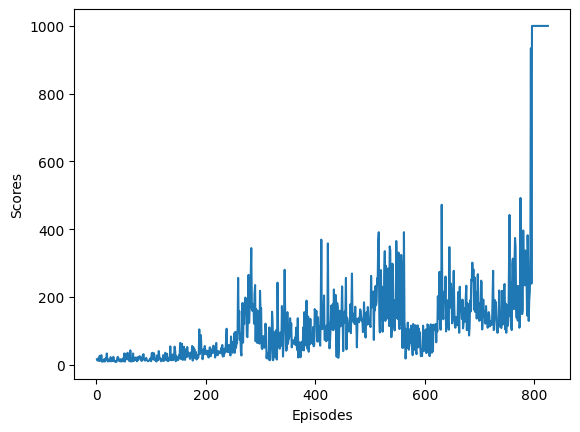

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel("Scores")
plt.xlabel("Episodes")
plt.show()

# Watch the agent

In [15]:
policy = Policy()
policy.load_state_dict(
    torch.load("policy_cartpole_reinforce.pth", map_location="cpu")
)
policy.eval()  # important: inference mode

Policy(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
def run_trained_policy(policy, env, max_t=1000):
    state, _ = env.reset()
    state = np.array(state)

    total_reward = 0

    for _ in range(max_t):
        state_t = torch.from_numpy(state).float().unsqueeze(0)

        with torch.no_grad():
            probs = policy(state_t)
            action = torch.argmax(probs, dim=1).item()

        state, reward, done, _, _ = env.step(action)
        total_reward += reward

        if done:
            break
        
    env.close()

    print("Total reward:", total_reward)

In [ ]:
env = gym.make('CartPole-v1', render_mode='human')
run_trained_policy(policy, env)